In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing 
from sklearn.metrics import accuracy_score,auc,confusion_matrix,classification_report,precision_score,roc_curve,roc_auc_score,recall_score,f1_score,precision_score
from sklearn import metrics
import missingno as mn
import math as m
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_palette('husl',8)

#### Reading the cleaned & merged dataset

In [2]:
sales_forecasting_df = pd.read_csv("sales_forecasting.csv")
print(sales_forecasting_df.head())
print(sales_forecasting_df.shape)

   Store  Dept        Date  Weekly_Sales    Size  Type_A  Type_B  Type_C  \
0      1     1  2010-02-05      24924.50  151315       1       0       0   
1      1     1  2010-02-12      46039.49  151315       1       0       0   
2      1     1  2010-02-19      41595.55  151315       1       0       0   
3      1     1  2010-02-26      19403.54  151315       1       0       0   
4      1     1  2010-03-05      21827.90  151315       1       0       0   

   Temperature  Fuel_Price         CPI  Unemployment  IsHoliday  
0        42.31       2.572  211.096358         8.106          0  
1        38.51       2.548  211.242170         8.106          1  
2        39.93       2.514  211.289143         8.106          0  
3        46.63       2.561  211.319643         8.106          0  
4        46.50       2.625  211.350143         8.106          0  
(421570, 13)


### 1. Viewing the average sales across the 3 store types

In [5]:
store_type = ['A','B','C']
average_sales = [sales_forecasting_df.loc[sales_forecasting_df['Type_A'] == 1, 'Weekly_Sales'].sum()/sales_forecasting_df.Type_A.sum(),
                 sales_forecasting_df.loc[sales_forecasting_df['Type_B'] == 1, 'Weekly_Sales'].sum()/sales_forecasting_df.Type_B.sum(),
                 sales_forecasting_df.loc[sales_forecasting_df['Type_C'] == 1, 'Weekly_Sales'].sum()/sales_forecasting_df.Type_C.sum()]

*Stores of Type A, have a much higher sales than types B & C*
##### *Hence, Store Size would also have an impact on Sales*

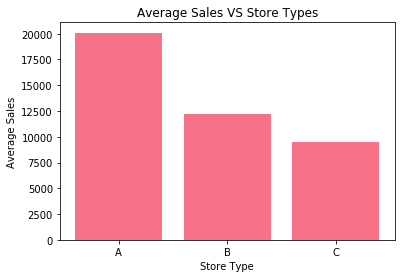

In [8]:
plt.bar(store_type, average_sales, align='center')
plt.title('Average Sales VS Store Types')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.show()

### 2. Viewing the average sales across Holiday week & Non Holiday week categories

In [9]:
Holiday_week = ['Yes','No']
average_sales = [sales_forecasting_df.loc[sales_forecasting_df['IsHoliday'] == 1, 'Weekly_Sales'].sum()/sales_forecasting_df.IsHoliday.sum(),
                 sales_forecasting_df.loc[sales_forecasting_df['IsHoliday'] == 0, 'Weekly_Sales'].sum()/(len(sales_forecasting_df)-sales_forecasting_df.IsHoliday.sum())]

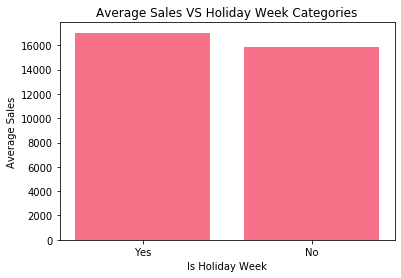

In [10]:
plt.bar(Holiday_week, average_sales, align='center')
plt.title('Average Sales VS Holiday Week Categories')
plt.xlabel('Is Holiday Week')
plt.ylabel('Average Sales')
plt.show()

### 3. Total Sales at Week & Store level

In [11]:
sales_week_store_lvl = sales_forecasting_df.groupby(['Store', 'Date']).agg({'Weekly_Sales': ['sum']})

Weekly_Sales
                          sum
Store Date                   
1     2010-02-05   1643690.90
      2010-02-12   1641957.44
      2010-02-19   1611968.17
      2010-02-26   1409727.59
      2010-03-05   1554806.68
...                       ...
45    2012-09-28    713173.95
      2012-10-05    733455.07
      2012-10-12    734464.36
      2012-10-19    718125.53
      2012-10-26    760281.43

[6435 rows x 1 columns]